In [1]:
import pandas as pd
import yfinance as yf
import datetime

# 데이터 불러오기
start = datetime.datetime(2020, 1, 1)
end = datetime.datetime(2024, 12, 27)
btc_data = yf.download('BTC-USD', start=start, end=end)

# 필요한 컬럼 선택
btc_data = btc_data[['Close']]

[*********************100%***********************]  1 of 1 completed


In [2]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# 데이터 정규화
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(btc_data)

# 학습 데이터 생성
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 60
X, y = create_dataset(scaled_data, time_step)

# 데이터 차원 변환 [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# 모델 생성
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# 모델 컴파일
model.compile(optimizer='adam', loss='mean_squared_error')

# 모델 학습
model.fit(X, y, epochs=20, batch_size=32, verbose=1)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0379
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0010
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0012
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.1386e-04
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 9.1224e-04
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 7.9875e-04
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 8.4844e-04
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 6.7805e-04
Epoch 9/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 6.9418e-04
Epoch 10/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.7741e-04
Epoch 11/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 4.7921e-04
Epoch 12/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 6.4982e-04
Epoch 13/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 8.1801e-04
Epoch 14/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4.8821e-04
Epoch 15/20
56/56 ━━━━━━━━━━

In [4]:
# 예측 데이터 생성
train_size = int(len(scaled_data) * 0.8)
test_data = scaled_data[train_size - time_step:]

X_test, y_test = create_dataset(test_data, time_step)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# 예측
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


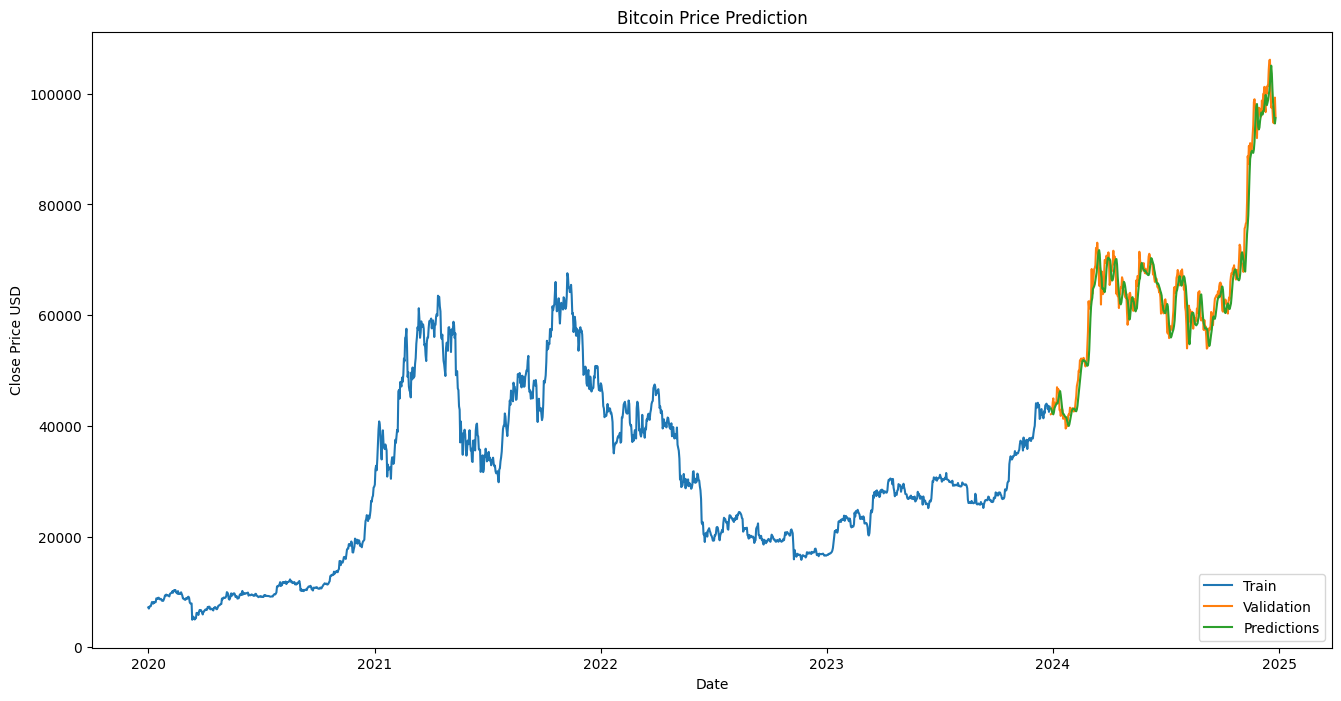

In [5]:
# 시각화
import matplotlib.pyplot as plt

train = btc_data[:train_size]
valid = btc_data[train_size:]

# 길이 맞추기
min_len = min(len(valid), len(predictions))  # 최소 길이 계산
valid = valid.iloc[-min_len:]  # valid를 최소 길이에 맞춰 슬라이싱
predictions = predictions[-min_len:]  # predictions도 최소 길이에 맞춰 슬라이싱

# Predictions 열 추가
valid['Predictions'] = predictions


# 시각화
plt.figure(figsize=(16, 8))
plt.title('Bitcoin Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price USD')
plt.plot(train['Close'], label='Train')
plt.plot(valid['Close'], label='Validation')
plt.plot(valid['Predictions'], label='Predictions')
plt.legend(loc='lower right')
plt.show()


In [6]:
# 예측 데이터와 실제 데이터만 출력
predicted_dates = valid.index  # 예측에 사용된 날짜
predicted_values = valid['Predictions'].values.flatten()  # 1차원으로 변환
actual_values = valid['Close'].values.flatten()  # 1차원으로 변환

# DataFrame으로 정리
results = pd.DataFrame({
    'Date': predicted_dates,
    'Actual': actual_values,
    'Predicted': predicted_values
})

print(results)


          Date        Actual     Predicted
0   2023-12-29  42099.402344  43151.238281
1   2023-12-30  42156.902344  42898.289062
2   2023-12-31  42265.187500  42546.289062
3   2024-01-01  44167.332031  42246.789062
4   2024-01-02  44957.968750  42071.875000
..         ...           ...           ...
359 2024-12-22  95104.937500  98460.390625
360 2024-12-23  94686.242188  96962.062500
361 2024-12-24  98676.093750  95582.929688
362 2024-12-25  99299.195312  94623.320312
363 2024-12-26  95795.515625  95551.445312

[364 rows x 3 columns]


In [7]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 예측값과 실제값
y_actual = valid['Close'].values.flatten()  # 실제값
y_pred = valid['Predictions'].values.flatten()  # 예측값

# MAE 계산
mae = mean_absolute_error(y_actual, y_pred)
print(f"Mean Absolute Error (MAE): {mae:.2f}")

# MSE 계산
mse = mean_squared_error(y_actual, y_pred)
print(f"Mean Squared Error (MSE): {mse:.2f}")

# RMSE 계산
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# R² 계산
r2 = r2_score(y_actual, y_pred)
print(f"R² (R-squared): {r2:.2f}")


Mean Absolute Error (MAE): 2341.68
Mean Squared Error (MSE): 9374117.43
Root Mean Squared Error (RMSE): 3061.72
R² (R-squared): 0.96


In [9]:
pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 7.1 MB/s eta 0:00:00


In [10]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

# 모델 빌드 함수
def build_model(hp):
    model = Sequential()
    model.add(LSTM(
        units=hp.Int('units', min_value=50, max_value=200, step=50),
        return_sequences=True,
        input_shape=(time_step, 1)
    ))
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(LSTM(units=hp.Int('units', min_value=50, max_value=200, step=50), return_sequences=False))
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(25))
    model.add(Dense(1))

    # 옵티마이저 선택
    model.compile(
        optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop']),
        loss='mean_squared_error'
    )
    return model

# 튜너 설정
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=40,  # 가능한 하이퍼파라미터 조합 수
    executions_per_trial=1,  # 각 조합에 대해 몇 번 실행할지
    directory='my_dir',
    project_name='lstm_tuning'
)

# 데이터셋 설정
tuner.search(X, y, epochs=10, validation_split=0.2)

# 최적의 하이퍼파라미터 결과 출력
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
Best number of units: {best_hps.get('units')}
Best dropout rate: {best_hps.get('dropout_rate')}
Best optimizer: {best_hps.get('optimizer')}
""")

# 최적의 하이퍼파라미터로 모델 재훈련
model = tuner.hypermodel.build(best_hps)
history = model.fit(X, y, epochs=50, validation_split=0.2)


Trial 39 Complete [00h 00m 10s]
val_loss: 0.000878657796420157

Best val_loss So Far: 0.000813360617030412
Total elapsed time: 00h 05m 38s

Best number of units: 200
Best dropout rate: 0.2
Best optimizer: adam

Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0110 - val_loss: 0.0025
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.8550e-04 - val_loss: 0.0024
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.4364e-04 - val_loss: 0.0016
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.7834e-04 - val_loss: 0.0021
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.2066e-04 - val_loss: 0.0013
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.0729e-04 - val_loss: 0.0013
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.0745e-04 - val_loss: 0.0018
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.6935e-04 - val_loss: 9.6296e-04
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.4580e-04 - val_l

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step


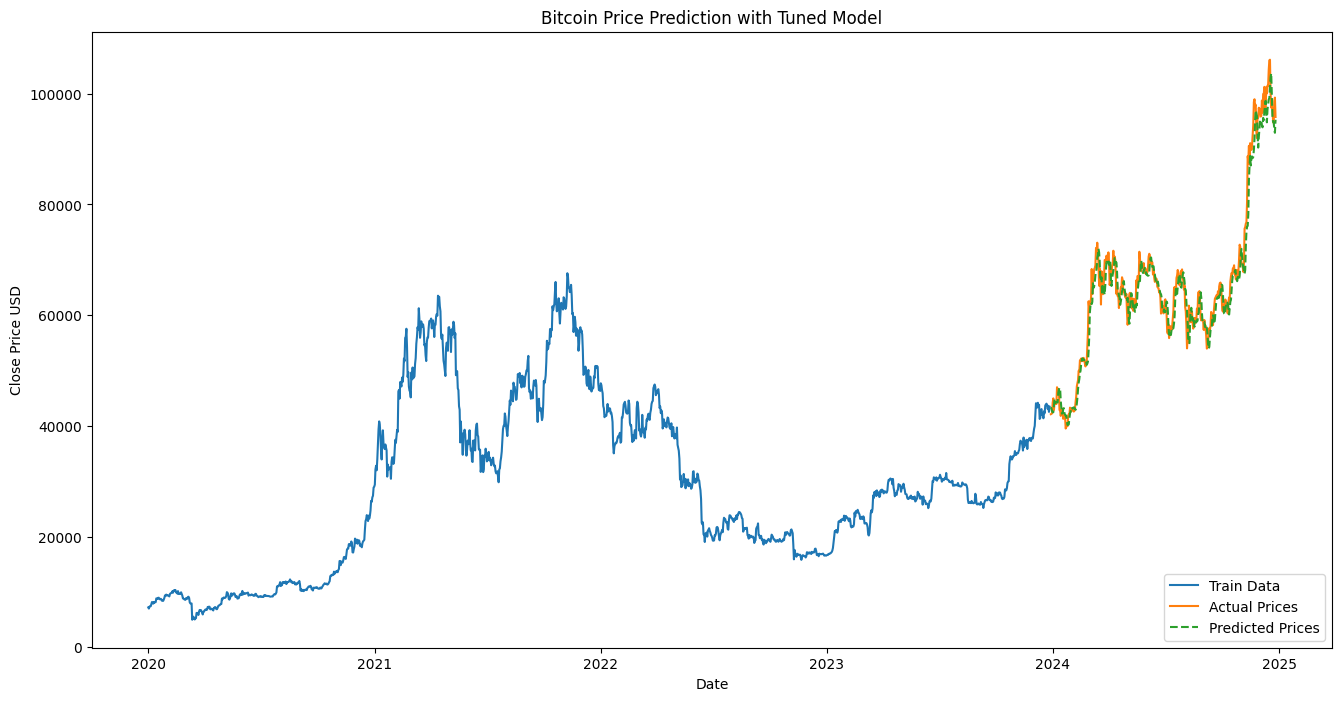

          Date        Actual     Predicted
0   2023-12-29  42099.402344  43347.960938
1   2023-12-30  42156.902344  43129.449219
2   2023-12-31  42265.187500  42651.433594
3   2024-01-01  44167.332031  42430.484375
4   2024-01-02  44957.968750  42456.800781
..         ...           ...           ...
359 2024-12-22  95104.937500  94914.968750
360 2024-12-23  94686.242188  94808.796875
361 2024-12-24  98676.093750  93707.625000
362 2024-12-25  99299.195312  92943.468750
363 2024-12-26  95795.515625  95293.859375

[364 rows x 3 columns]


In [11]:
# 예측 데이터 준비
X_test, y_test = create_dataset(test_data, time_step)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# 최적 모델로 예측
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# 시각화를 위해 valid 데이터의 길이를 predictions와 동일하게 조정
min_len = min(len(valid), len(predictions))  # 최소 길이 계산
valid = valid.iloc[-min_len:]  # valid 슬라이싱
predictions = predictions[-min_len:]  # predictions 슬라이싱

# Predictions 열 추가
valid['Predictions'] = predictions

# 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
plt.title('Bitcoin Price Prediction with Tuned Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD')
plt.plot(train['Close'], label='Train Data')
plt.plot(valid['Close'], label='Actual Prices')
plt.plot(valid['Predictions'], label='Predicted Prices', linestyle='--')
plt.legend(loc='lower right')
plt.show()

# 예측 데이터와 실제 데이터만 출력
predicted_dates = valid.index  # 예측에 사용된 날짜
predicted_values = valid['Predictions'].values.flatten()  # 1차원으로 변환
actual_values = valid['Close'].values.flatten()  # 1차원으로 변환

# DataFrame으로 정리
results = pd.DataFrame({
    'Date': predicted_dates,
    'Actual': actual_values,
    'Predicted': predicted_values
})

print(results)

In [13]:
# 예측값과 실제값
y_actual = valid['Close'].values.flatten()  # 실제값
y_pred = valid['Predictions'].values.flatten()  # 예측값

# MAE 계산
mae = mean_absolute_error(y_actual, y_pred)
print(f"Mean Absolute Error (MAE): {mae:.2f}")

# MSE 계산
mse = mean_squared_error(y_actual, y_pred)
print(f"Mean Squared Error (MSE): {mse:.2f}")

# RMSE 계산
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# R² 계산
r2 = r2_score(y_actual, y_pred)
print(f"R² (R-squared): {r2:.2f}")

Mean Absolute Error (MAE): 2087.31
Mean Squared Error (MSE): 7916097.85
Root Mean Squared Error (RMSE): 2813.56
R² (R-squared): 0.96
